## Brain Tumor Classification with CNNs

### Imports

In [1]:
# Common Python imports
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import matplotlib.image as mpimg
from IPython.display import Image
import random
# import tqdm.notebook as tqdm

# Torch imports
import torch as th

# Typining hints
from typing import List, Union, Callable

# Change cwd to the parent directory and add it to the Python path
os.chdir("/home/marco/deep-learning-project/")
sys.path.append(os.getcwd())
print(f"Current working directory: 📂 {os.getcwd()}")

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
	},
)

# Model import
from models.alexnet import AlexNet_128
from models.custom_cnn import CustomCNN
from models.vgg16 import VGG16_128

# Dataset loader
from utils.datasets import load_segmentation, load_single

# Utils imports
from utils.analysis import *
from utils.metrics import *
from utils.train import *

Current working directory: 📂 /home/marco/deep-learning-project


### Hyperparameters

In [2]:
# Training hyperparameters
PERCENTAGE: float   = 0.5
SPLIT: float        = 0.9
N_FILTERS: int      = 32
IMG_SIZE: int       = 240
EPOCHS: int         = 20
BATCH_TRAIN: int    = 32
BATCH_VALID: int    = 32
LR: float           = 2e-3
WEIGHT_DECAY: float = 1e-2
GAMMA: float        = 0.9


# Loss function
CRITERION: Union[th.nn.Module, Callable[[th.Tensor, th.Tensor], th.Tensor]] = (
	th.nn.BCEWithLogitsLoss()
)


# Dataset, Models and Metrics folders
DATASETS: str = "datasets"
CLASSIFICATION: str = os.path.join(DATASETS, "classification")
TRAINING: str = os.path.join(CLASSIFICATION, "Training")
TESTING: str = os.path.join(CLASSIFICATION, "Testing")
SAVE_MODELS_PATH: str = f"models/saved_models"
SAVE_METRICS_PATH: str = f"models/saved_metrics"


# Device setup
device: th.device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Using device: 💻 {device}")

Using device: 💻 cpu


TODO: Plot 4 Images with relative label
TODO: GIf of segmentation and classification prediction as demo of the readme

### Dataset

We start off with a small exploratory analysis of the dataset. We will load the dataset and check the distribution of the classes.

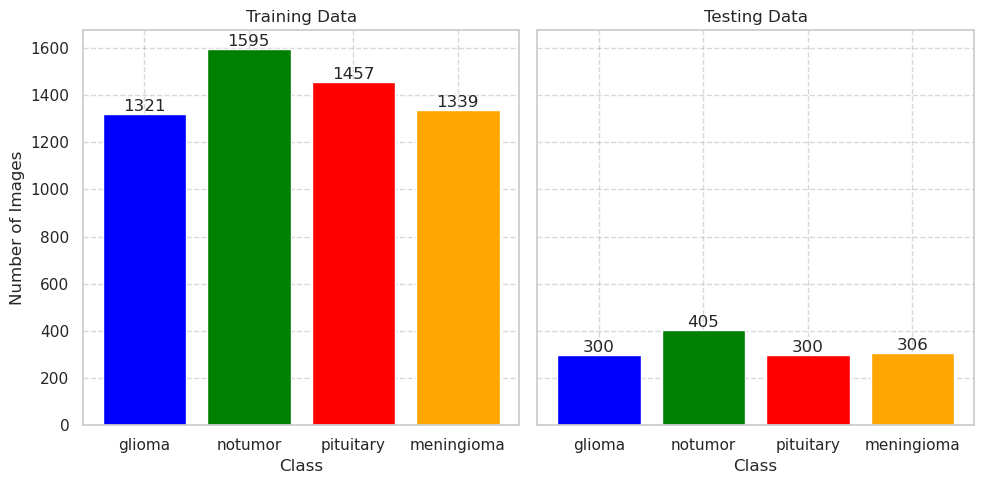

In [4]:
def count_images_in_classes(base_dir):
    counts = {}
    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len(os.listdir(class_dir))
    return counts

# Count the images in each class for training and testing
train_counts = count_images_in_classes(TRAINING)
test_counts = count_images_in_classes(TESTING)

# Create DataFrames for plotting
train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
test_df = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])

# Define a color palette for the classes
color_palette = {
    'glioma': 'blue',
    'meningioma': 'orange',
    'notumor': 'green',
    'pituitary': 'red'
}

# Plot the counts
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Training data plot
bars = axes[0].bar(train_df['Class'], train_df['Count'], color=[color_palette[class_name] for class_name in train_df['Class']])
axes[0].set_title('Training Data')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Images')

# Add annotations on top of the bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

# Testing data plot
bars = axes[1].bar(test_df['Class'], test_df['Count'], color=[color_palette[class_name] for class_name in test_df['Class']])
axes[1].set_title('Testing Data')
axes[1].set_xlabel('Class')

# Add annotations on top of the bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

We can also attempt to see how the images look like.

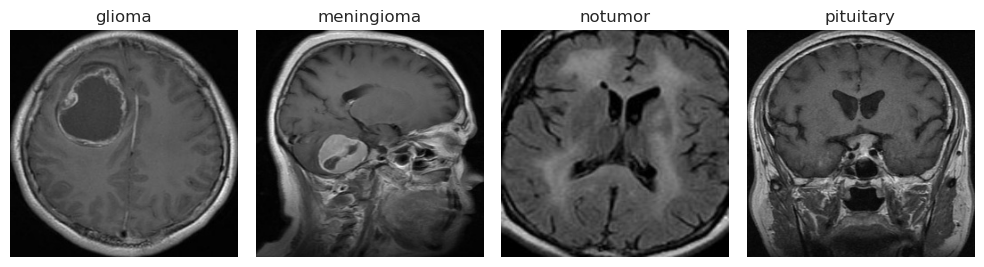

In [30]:
def get_random_image_from_class(base_dir, class_name):
    class_dir = os.path.join(base_dir, class_name)
    image_files = os.listdir(class_dir)
    random_image = random.choice(image_files)
    return os.path.join(class_dir, random_image)

# Define the path to the training directory
train_dir = TRAINING

# Define the class names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Get a random image from each class
random_images = [get_random_image_from_class(train_dir, class_name) for class_name in classes]

# Plot the images in a 1x4 grid
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

for ax, img_path, class_name in zip(axes, random_images, classes):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()